In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings( 'ignore' )

In [2]:
data = pd.read_csv("heart.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
data.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
sc = StandardScaler()
data.iloc[:,:-1] = sc.fit_transform(data.iloc[:,:-1])

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

In [8]:
x_train, y_train = train.drop('target',1), train['target']
x_test, y_test = test.drop('target',1), test['target']

In [9]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [10]:
lr.fit(x_train,y_train)

LogisticRegression()

In [11]:
loan_col=[]
for i in data.columns:
    loan_col.append(i)

loan_col.remove('target')
loan_col

['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal']

In [12]:
# 데이터 컬럼에 따른 beta, exp(beta) 체크
column_name = ["const"] + loan_col
beta = np.concatenate([lr.intercept_,lr.coef_.reshape(-1)]).round(2) # round(2) 소수점 둘째짜리까지 반올림
odds = np.exp(beta).round(2) # round(2) 소수점 둘째짜리까지 반올림
interpret = np.where(beta>0,'risky','protective') # np.where() 조건문 

# beta 해석 정리
beta_analysis = pd.DataFrame(np.c_[beta,odds,interpret],index=column_name,columns=['beta','exp(beta)','interpret'])
beta_analysis

,beta,exp(beta),interpret
const,-0.07,0.93,protective
age,0.03,1.03,risky
sex,-0.65,0.52,protective
cp,0.83,2.29,risky
trestbps,-0.15,0.86,protective
chol,-0.12,0.89,protective
fbs,0.21,1.23,risky
restecg,0.38,1.46,risky
thalach,0.37,1.45,risky
exang,-0.59,0.55,protective


In [13]:
beta_analysis.loc[beta_analysis.interpret=='protective'].index

Index(['const', 'sex', 'trestbps', 'chol', 'exang', 'oldpeak', 'ca', 'thal'], dtype='object')

In [14]:
beta_analysis.loc[beta_analysis.interpret!='protective'].index

Index(['age', 'cp', 'fbs', 'restecg', 'thalach', 'slope'], dtype='object')

In [15]:
y_pred = lr.predict_proba(x_test)
predict_prob = pd.DataFrame(lr.predict_proba(x_test),columns=['P(Y=0)','P(Y=1)'])
P_1 = predict_prob['P(Y=1)']

In [16]:
#성능 평가하기
#Cut off 값을 변화하면서 Accuracy 성능 관찰
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, recall_score, precision_score
Cut_off = np.linspace(0,1,11) ## cut off 값 여러개 만들어두기
for cutoff in Cut_off:
    y_pred = np.where(P_1>=cutoff,1,0) # 확률값이 cuf off보다 크면 1(대출연체), 아니면 0(연체x)
    acc = accuracy_score(y_true = y_test, y_pred =y_pred) ## 정확도
    recall = recall_score(y_true = y_test, y_pred =y_pred) ## 민감도
    precision = precision_score(y_true = y_test, y_pred =y_pred) ## 정밀도
    
#     print('Testing MSE: {:.3f}'.format(mean_squared_error(y_test, y_pred)))
#     print('Testing RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
#     print('Testing MAE: {:.3f}'.format(mean_absolute_error(y_test, y_pred)))
#     print('Testing R2: {:.3f}'.format(r2_score(y_test, y_pred)))
    print(f"Accuracy:{acc:0.2f}",f"Recall:{recall:0.2f}",f"Precision:{precision:0.2f}", f"cut off:{cutoff:0.2f}",sep='  |  ') 

Accuracy:0.55  |  Recall:1.00  |  Precision:0.55  |  cut off:0.00
Accuracy:0.81  |  Recall:0.92  |  Precision:0.78  |  cut off:0.10
Accuracy:0.85  |  Recall:0.92  |  Precision:0.82  |  cut off:0.20
Accuracy:0.85  |  Recall:0.90  |  Precision:0.83  |  cut off:0.30
Accuracy:0.81  |  Recall:0.84  |  Precision:0.82  |  cut off:0.40
Accuracy:0.81  |  Recall:0.84  |  Precision:0.82  |  cut off:0.50
Accuracy:0.80  |  Recall:0.80  |  Precision:0.83  |  cut off:0.60
Accuracy:0.80  |  Recall:0.72  |  Precision:0.90  |  cut off:0.70
Accuracy:0.71  |  Recall:0.56  |  Precision:0.88  |  cut off:0.80
Accuracy:0.62  |  Recall:0.36  |  Precision:0.86  |  cut off:0.90
Accuracy:0.45  |  Recall:0.00  |  Precision:0.00  |  cut off:1.00


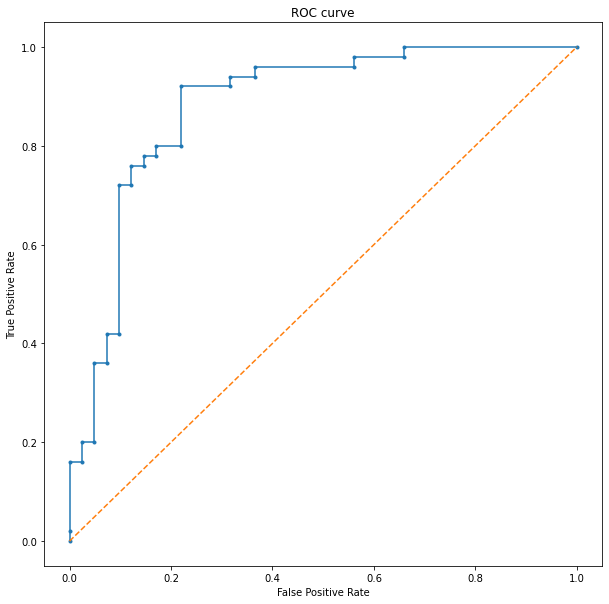

In [19]:
# X_test에 대한 P(Y=1) 예측 확률값 - 패키지 이용
probs = lr.predict_proba(x_test)[:, 1] ## [:,1]은 두번째 컬럼을 indexing 한다는 뜻
 
# Roc curve X 축, Y축 추출
model_fpr, model_tpr, threshold1 = roc_curve(y_test, probs)
random_fpr, random_tpr, threshold2 = roc_curve(y_test, [0 for i in range(x_test.__len__())])

# plot the roc curve for the model and random
plt.figure(figsize=(10,10))
plt.plot(model_fpr, model_tpr, marker='.', label='Logistic')
plt.plot(random_fpr, random_tpr, linestyle='--', label='Random')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
 
# # show the legend
# plt.legend(fontsize=20)
 
# show the plot
plt.title("ROC curve")
plt.show()